### Processamento, sistema de recomendação e classificação de textos

Nosso objetivo nesse notebook é fazer três coisas:

__1 - Falar sobre pré-processamento que podemos fazer em textos incluindo a criação de uma classe que faz todo o pré-processamento, redimensionamento e clusterização de textos__

__2 - Criar um sistema de recomendação de textos, onde o usuário vai entrar com um dos temas pré definidos:__

- Technology
- Sports
- Politics

__E o sistema vai recomendar um texto de uma das categórias baseado na clusterização feita antes, além disso conseguiremos alimentar o sistema com uma tabela de usuário x item, na qual pode ser usada em um futuro para outras tecnicas de sistema de recomendações__

Aqui faremos um sistema simples, mas que já da pra entender a ideia principal e que pode ser pensando e melhorado para determinado tipos de situações.

__3 - Com base na clusterização feita inicialmente, criar uma função que permite o usuário colocar um texto e a função nos retorna a classificação, se aquele texto é sobre esportes, politica ou tecnologia.__

In [1]:
# importando as biblitecas necessárias inicialmente

import re
import os
import emoji
import spacy
import string
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

Iremos aqui fazer um Webscrapping no site https://inshorts.com/, nele temos varias pequenas materias sobre vários temas, para nosso exemplo, escolheremos três temas bem distintos e trabalharemos com eles.

In [2]:
seed_urls = ['https://inshorts.com/en/read/technology',
             'https://inshorts.com/en/read/sports',
             'https://inshorts.com/en/read/politics' ]

def build_dataset(seed_urls):
    news_data = []
    for url in seed_urls:
        news_category = url.split('/')[-1]
        data = requests.get(url)
        soup = BeautifulSoup(data.content, 'html.parser')
        
        news_articles = [{'news_headline': headline.find('span', 
                                                         attrs={"itemprop": "headline"}).string,
                          'news_article': article.find('div', 
                                                       attrs={"itemprop": "articleBody"}).string,
                          'news_category': news_category}
                         
                            for headline, article in 
                             zip(soup.find_all('div', 
                                               class_=["news-card-title news-right-box"]),
                                 soup.find_all('div', 
                                               class_=["news-card-content news-right-box"]))
                        ]
        news_data.extend(news_articles)
        
    df =  pd.DataFrame(news_data)
    df = df[['news_headline', 'news_article', 'news_category']]
    return df

In [3]:
# construndo o dataset com a função acima

news_df = build_dataset(seed_urls)
news_df

,news_headline,news_article,news_category
0,S Korean college's toilet makes power from poo...,South Korea's Ulsan National Institute of Scie...,technology
1,101-carat diamond auctioned for ₹91 crore in c...,A 101.38-carat diamond has been auctioned at S...,technology
2,SC to hear Centre's plea on transfer of petiti...,The Supreme Court has said the Centre's plea s...,technology
3,Microsoft giving ₹1.1 lakh pandemic bonus to e...,"Microsoft is giving a $1,500 (over ₹1.1 lakh) ...",technology
4,Amazon asks managers to hide performance-impro...,Amazon instructs its managers not to let emplo...,technology
...,...,...,...
70,"Uttarakhand CM meets PM Modi, requests AIIMS i...",Newly-appointed Uttarakhand CM Pushkar Singh D...,politics
71,"Oppn must come together, else history won't fo...","Leader of Opposition in Bihar Assembly, Tejash...",politics
72,He's admired across the spectrum: PM Modi on R...,PM Narendra Modi on Saturday greeted Defence M...,politics
73,200 people will protest near Parliament from J...,Bhartiya Kisan Union (BKU) leader Rakesh Tikai...,politics


A função que vamos usar abaixo faz duas coisas:

- pré-processamento padrão, retirando stopwwords, emojis, números e etc
- tokenização do texto, isto é colocar todo o texto separado por palavras em uma lista.

In [5]:
def preprocess_text(text, remove_stop = True, stem_words = False, remove_mentions_hashtags = True):
    """
    eg:
    input: preprocess_text("@water #dream hi hello where are you going be there tomorrow happening happen happens",  
    stem_words = True) 
    output: ['tomorrow', 'happen', 'go', 'hello']
    """

    # Remove emojis
    emoji_pattern = re.compile("[" "\U0001F1E0-\U0001F6FF" "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r"", text)
    text = "".join([x for x in text if x not in emoji.UNICODE_EMOJI])

    if remove_mentions_hashtags:
        text = re.sub(r"@(\w+)", " ", text)
        text = re.sub(r"#(\w+)", " ", text)

    text = re.sub(r"[^\x00-\x7F]+", " ", text)
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]') # remove punctuation and numbers
    nopunct = regex.sub(" ", text.lower())
    words = (''.join(nopunct)).split()

    if(remove_stop):
        words = [w for w in words if w not in ENGLISH_STOP_WORDS]
        words = [w for w in words if len(w) > 2]  # remove a,an,of etc.

    if(stem_words):
        stemmer = PorterStemmer()
        words = [stemmer.stem(w) for w in words]

    return list(words)

In [6]:
rows, cols = news_df.shape

In [7]:
news_df1 = news_df.copy() # criando uma copia para o caso de ser necessário o uso do dataset em sua primeira versão

news_df['token'] = [preprocess_text(news_df["news_article"][row]) for row in range(rows)]

In [8]:
# visualizando o dataset criado

news_df

,news_headline,news_article,news_category,token
0,S Korean college's toilet makes power from poo...,South Korea's Ulsan National Institute of Scie...,technology,"[south, korea, ulsan, national, institute, sci..."
1,101-carat diamond auctioned for ₹91 crore in c...,A 101.38-carat diamond has been auctioned at S...,technology,"[carat, diamond, auctioned, sotheby, crore, mi..."
2,SC to hear Centre's plea on transfer of petiti...,The Supreme Court has said the Centre's plea s...,technology,"[supreme, court, said, centre, plea, seeking, ..."
3,Microsoft giving ₹1.1 lakh pandemic bonus to e...,"Microsoft is giving a $1,500 (over ₹1.1 lakh) ...",technology,"[microsoft, giving, lakh, pandemic, bonus, emp..."
4,Amazon asks managers to hide performance-impro...,Amazon instructs its managers not to let emplo...,technology,"[amazon, instructs, managers, let, employees, ..."
...,...,...,...,...
70,"Uttarakhand CM meets PM Modi, requests AIIMS i...",Newly-appointed Uttarakhand CM Pushkar Singh D...,politics,"[newly, appointed, uttarakhand, pushkar, singh..."
71,"Oppn must come together, else history won't fo...","Leader of Opposition in Bihar Assembly, Tejash...",politics,"[leader, opposition, bihar, assembly, tejashwi..."
72,He's admired across the spectrum: PM Modi on R...,PM Narendra Modi on Saturday greeted Defence M...,politics,"[narendra, modi, saturday, greeted, defence, m..."
73,200 people will protest near Parliament from J...,Bhartiya Kisan Union (BKU) leader Rakesh Tikai...,politics,"[bhartiya, kisan, union, bku, leader, rakesh, ..."


Vamos comparar o primeiro texto do dataset antes e depois do pré-processamento:

In [9]:
news_df['news_article'][0]

"South Korea's Ulsan National Institute of Science and Technology professors have designed a toilet that converts methane from one's faeces into a power source for the appliances in the building, including gas stove, a professor said. Students using the toilet are rewarded with 10 units of digital currency 'Ggool' per day, which can be used to buy things on campus."

In [10]:
print(news_df['token'][0])

['south', 'korea', 'ulsan', 'national', 'institute', 'science', 'technology', 'professors', 'designed', 'toilet', 'converts', 'methane', 'faeces', 'power', 'source', 'appliances', 'building', 'including', 'gas', 'stove', 'professor', 'said', 'students', 'using', 'toilet', 'rewarded', 'units', 'digital', 'currency', 'ggool', 'day', 'used', 'buy', 'things', 'campus']


### Vetorização

O próximo passo vai ser a vetorização dos nossos textos, a biblioteca que nos permite fazer isso de maneira eficiente é a spacy:

[Documentação spacy](https://spacy.io/usage)

In [11]:
nlp = spacy.load('en_core_web_md')

# definindo função que retorna os vetores para cada palavra:

def vec(s):
    return nlp.vocab[s].vector


Para entender um pouco o que a vetorização está fazendo, vamos pegar a primeira palavra do primeiro texto do dataset

In [12]:
nlp.vocab[news_df['token'][0][0]].vector

array([ 3.0233e-01,  1.0602e-01,  3.4486e-01, -1.7187e-01,  1.1376e+00,
        1.2113e-01, -4.4904e-01,  5.8672e-01,  1.2389e-01,  2.7719e+00,
       -4.8481e-01, -1.0983e-01,  2.7575e-01, -2.7715e-01, -2.8142e-01,
       -4.1233e-02,  1.6334e-01,  1.3552e+00,  5.0799e-01, -2.7932e-01,
        3.5309e-01,  3.7836e-01,  5.3228e-01, -5.8108e-04, -1.2489e-02,
       -4.4130e-01, -6.0205e-02, -1.3591e-01, -1.5055e-01,  4.0398e-01,
        3.7536e-01,  4.6984e-01, -2.6681e-01,  2.4657e-02, -4.6052e-01,
        7.8195e-02, -3.1437e-01,  6.5725e-02, -4.1573e-01, -2.8379e-02,
       -4.1889e-01,  8.0712e-02,  4.8615e-01,  4.4394e-03,  1.6153e-01,
       -3.2498e-02,  2.6039e-01, -2.9447e-01, -5.2268e-01, -2.9064e-01,
        1.3021e-01,  2.3819e-01, -1.6416e-01,  7.7372e-02,  1.5120e-01,
        4.7038e-01, -9.3803e-02,  2.4088e-01, -4.7686e-02,  2.0386e-01,
       -2.6520e-01, -9.1300e-02,  1.9710e-01,  8.2668e-01, -1.2207e-02,
        2.8575e-01,  1.0221e-01,  3.6869e-01,  1.4288e-01,  2.50

In [13]:
# conferindo o tamanho

nlp.vocab[news_df['token'][0][0]].vector.shape

(300,)

In [14]:
news_df['token'][0][0]

'south'

Transformamos a palavra 'south' em um vetor com 300 colunas, agora faremos isso com todas as palavras de todos os textos.

In [15]:
vec_size = 300
list_of_matrix = [] #criando uma lista vazia que vai ser preenchida no final do código
for corpus in news_df['token']: # pegando cada noticia na coluna 'token'
    matrix = np.empty([len(corpus), vec_size]) # criando uma matriz vazia, com quantidade de linhas sendo a quantidade de palavras
                                               # da noticia e 300 colunas
    for idx, word in enumerate(corpus):
        matrix[idx,:] = vec(word) # adicionando em cada uma das 300 colunas, as palavras vetorizadas
    list_of_matrix.append(matrix) # adicionando cada matriz nova a lista vazia criada no começo, cada elemento dessa lista, possui
                                  # a quantidade de palavras da materia de linhas e 300 colunas

### O código acima nos retorna uma lista de matrizes, cada elemento dessa lista é uma matriz, com as palavras da materia e cada uma dessas palavras vetorizadas.

#### Por exemplo, a primeira materia tem 35 palavras, logo ao ver o tamanho da primeira matriz dessa lista, devemos ter uma matriz de tamanho (35,300), vamos conferir:

In [17]:
len(news_df['token'][0]), list_of_matrix[0].shape

(35, (35, 300))

Agora iremos criar uma matriz final, para isso pegaremos cada um dos elementos da lista de matriz criada acima, e cacularemos a média em relação as linhas.

Ao final, teremos uma matriz com 75 linhas (quantidade de matérias) e 300 colunas ( representação de cada materia pela média de cada palavra dela vetorizada)

In [18]:
final_feature_matrix = np.empty([rows, vec_size])

for row in range(rows):
    final_feature_matrix[row,:] = list_of_matrix[row].mean(axis = 0)

In [19]:
final_feature_matrix

array([[-0.05112883,  0.01279246,  0.15757324, ...,  0.00571164,
         0.00928433,  0.16328086],
       [-0.15604249,  0.28972959,  0.08924858, ..., -0.24731129,
         0.0388306 ,  0.35225023],
       [ 0.07318612,  0.1322581 , -0.00988987, ..., -0.06427381,
         0.15191296,  0.21147284],
       ...,
       [ 0.05282876,  0.13511844,  0.12018356, ...,  0.02290274,
        -0.01877232,  0.02261794],
       [-0.08782356,  0.16876584, -0.02366944, ...,  0.08170322,
         0.04187412,  0.16789795],
       [-0.24058759,  0.10707956,  0.2652065 , ...,  0.14049404,
        -0.06892216,  0.14375159]])

In [20]:
final_feature_matrix.shape

(75, 300)

Já fizemos todo o processamento nos textos, já podemos fazer a clusterização para dividir nossos dados. Porém, para explorar um pouco mais nossas possibilidades, vamos fazer um redimensionamento, afinal, estamos com 300 colunas. 

Vamos escolher dois modelos de redimensionamento, fazer a clusterização em cada um dos novos dados e escolher o melhor resultado para nosso modelo final. 

### Redimensionamento - PCA

vamos fazer o primeiro redimensionamento com o PCA (Principal component analysis).

[Documentação PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html?highlight=pca#sklearn.decomposition.PCA)

Iremos fazer dois testes, primeiro vamos reduzir para 20 variáveis e depois vamos reduzir para apenas duas variáveis.

In [21]:
from sklearn.decomposition import PCA
pca = PCA(n_components=20)
principalComponents = pca.fit_transform(final_feature_matrix)

In [22]:
# note que diminuimos realmente de 300 para 20 variáveis

principalComponents.shape

(75, 20)

In [23]:
# como temos três categorias, vamos fazer o agrupamento em três clusters

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=0).fit(principalComponents)
kmeans.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 2, 0, 2, 1, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2])

In [24]:
# conferindo a clusterização de acordo com as materias do dataset

print(news_df["news_category"][kmeans.labels_ == 0]) 
print(news_df["news_category"][kmeans.labels_ == 1])
print(news_df["news_category"][kmeans.labels_ == 2])

13    technology
25        sports
27        sports
30        sports
31        sports
33        sports
34        sports
35        sports
37        sports
38        sports
39        sports
40        sports
41        sports
42        sports
43        sports
44        sports
45        sports
46        sports
47        sports
48        sports
49        sports
Name: news_category, dtype: object
0     technology
1     technology
2     technology
3     technology
4     technology
5     technology
6     technology
7     technology
8     technology
9     technology
10    technology
11    technology
12    technology
14    technology
15    technology
16    technology
17    technology
18    technology
19    technology
20    technology
21    technology
22    technology
23    technology
24    technology
29        sports
52      politics
56      politics
Name: news_category, dtype: object
26      sports
28      sports
32      sports
36      sports
50    politics
51    politics
53    politics
54    pol

Não conseguimos separar 100% todas as categorias, mas conseguimos um ótimo resultado, vamos fazer o teste agora reduzindo para apenas duas dimensões.

In [25]:
pca2 = PCA(n_components=2)
principalComponents2 = pca2.fit_transform(final_feature_matrix)
kmeans2 = KMeans(n_clusters=3, random_state=0).fit(principalComponents2)

In [26]:
print(news_df["news_category"][kmeans2.labels_ == 0]) 
print(news_df["news_category"][kmeans2.labels_ == 1])
print(news_df["news_category"][kmeans2.labels_ == 2])

13    technology
25        sports
27        sports
30        sports
31        sports
33        sports
34        sports
35        sports
37        sports
38        sports
39        sports
40        sports
41        sports
42        sports
43        sports
44        sports
45        sports
46        sports
47        sports
48        sports
49        sports
Name: news_category, dtype: object
23    technology
26        sports
28        sports
32        sports
36        sports
50      politics
51      politics
53      politics
54      politics
55      politics
57      politics
58      politics
59      politics
60      politics
61      politics
62      politics
63      politics
64      politics
65      politics
66      politics
67      politics
68      politics
69      politics
70      politics
71      politics
72      politics
73      politics
74      politics
Name: news_category, dtype: object
0     technology
1     technology
2     technology
3     technology
4     technology
5     techno

Como estamos em duas dimensões, podemos comparar graficamente as categorias reais com as categorias agrupadas pelo KMeans

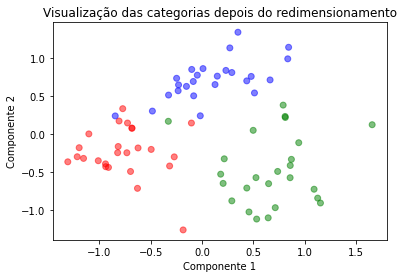

In [27]:
x = principalComponents2[:,0]
y = principalComponents2[:,1]

colors = {'technology':'red', 'politics':'blue', 'sports':'green'}
plt.scatter(x, y, alpha=0.5, c = news_df['news_category'].apply(lambda x: colors[x]))
plt.title('Visualização das categorias depois do redimensionamento')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.show()

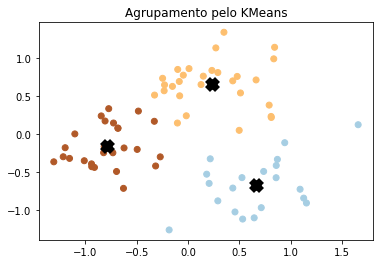

In [28]:
plt.title('Agrupamento pelo KMeans')
plt.scatter(x, y,  
            c = kmeans2.predict(principalComponents2), cmap = plt.cm.Paired)
for centr in kmeans2.cluster_centers_:
    plt.scatter(centr[0], centr[1], s = 100, marker = 'x', c = 'black', lw = 7)
plt.show()

Muito interessante como conseguimos uma ótima separação dos dados. Vamos repetir o processo com outro modelo de redimensionamento, o ICA

### Redimensionamento - ICA (Independent Component Analysis)

[Documentação ICA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FastICA.html?highlight=ica#sklearn.decomposition.FastICA)

Vamos repetir o processo que fizemos para o PCA, isto é, faremos dois redimensionamentos, um com 20 variáveis e outro com 2 variáveis.


In [29]:
from sklearn.decomposition import FastICA

In [30]:
ica = FastICA(n_components=20, random_state= 0)
principalComponents3 = ica.fit_transform(final_feature_matrix)

kmeans3 = KMeans(n_clusters=3, random_state=0).fit(principalComponents3)
kmeans3.labels_

array([0, 0, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2,
       0, 2, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0,
       0, 0, 2, 2, 0, 0, 2, 1, 0, 2, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 2,
       1, 2, 1, 1, 2, 1, 1, 1, 1])

In [31]:
print(news_df["news_category"][kmeans3.labels_ == 0]) 
print(news_df["news_category"][kmeans3.labels_ == 1])
print(news_df["news_category"][kmeans3.labels_ == 2])

0     technology
1     technology
3     technology
4     technology
12    technology
13    technology
22    technology
25        sports
26        sports
29        sports
30        sports
31        sports
32        sports
33        sports
35        sports
36        sports
37        sports
38        sports
40        sports
41        sports
43        sports
44        sports
45        sports
48        sports
49        sports
52      politics
Name: news_category, dtype: object
51    politics
55    politics
57    politics
58    politics
59    politics
61    politics
62    politics
63    politics
66    politics
68    politics
69    politics
71    politics
72    politics
73    politics
74    politics
Name: news_category, dtype: object
2     technology
5     technology
6     technology
7     technology
8     technology
9     technology
10    technology
11    technology
14    technology
15    technology
16    technology
17    technology
18    technology
19    technology
20    technology
21    te

Pelo que percebemos, o redimensionamento para 20 variáveis não foi tão preciso, vamos ver agora para 2 variáveis.

In [32]:
ica2 = FastICA(n_components=2, random_state= 0)
principalComponents4 = ica2.fit_transform(final_feature_matrix)

kmeans4 = KMeans(n_clusters=3, random_state=0).fit(principalComponents4)
kmeans4.labels_

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 1, 2, 0, 1, 0, 1, 2, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1])

In [33]:
print(news_df["news_category"][kmeans4.labels_ == 0]) 
print(news_df["news_category"][kmeans4.labels_ == 1])
print(news_df["news_category"][kmeans4.labels_ == 2])

13    technology
25        sports
27        sports
30        sports
31        sports
33        sports
34        sports
35        sports
37        sports
38        sports
39        sports
40        sports
41        sports
42        sports
43        sports
44        sports
45        sports
46        sports
47        sports
48        sports
49        sports
Name: news_category, dtype: object
23    technology
26        sports
28        sports
32        sports
36        sports
50      politics
51      politics
53      politics
54      politics
55      politics
57      politics
58      politics
59      politics
60      politics
61      politics
62      politics
63      politics
64      politics
65      politics
66      politics
67      politics
68      politics
69      politics
70      politics
71      politics
72      politics
73      politics
74      politics
Name: news_category, dtype: object
0     technology
1     technology
2     technology
3     technology
4     technology
5     techno

Para duas dimensões, conseguimos os mesmos resultados que o feito com o PCA para duas dimensões também, vamos olhar graficamente.

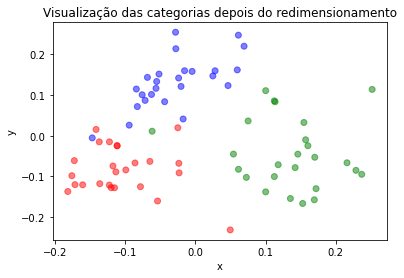

In [34]:
x2 = principalComponents4[:,0]
y2 = principalComponents4[:,1]

colors = {'technology':'red', 'politics':'blue', 'sports':'green'}
plt.scatter(x2, y2, alpha=0.5, c = news_df['news_category'].apply(lambda x: colors[x]))
plt.title('Visualização das categorias depois do redimensionamento')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

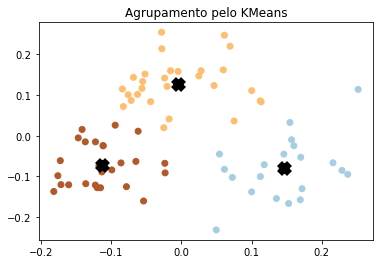

In [35]:
plt.title('Agrupamento pelo KMeans')
plt.scatter(x2, y2,  
            c = kmeans4.predict(principalComponents4), cmap = plt.cm.Paired)
for centr in kmeans4.cluster_centers_:
    plt.scatter(centr[0], centr[1], s = 100, marker = 'x', c = 'black', lw = 7)
plt.show()

### Criando uma classe de Pré-Processamento.

Será que conseguimos juntar tudo isso que fizemos até agora em um único lugar? A resposta é sim, conseguimos, vamos fazer isso criando uma classe, que fará tudo isso que fizemos antes, desde o pré-processamento, tokenização, redimensionamento, clusterização e por fim, nos mostrará um gráfico, caso o redimensionamento sejá feito para duas variáveis.

In [36]:
class preprocessamento_total():
    
    def __init__(self, data, coluna):
        self.data = data
        self.coluna = coluna
        self.rows = data.shape[0]
        self.cols = data.shape[1]
        self.final_feature_matrix = np.empty([self.rows, 300])
        list_of_matrix = []
    
    def preprocess(self):
        self.data['token'] = [preprocess_text(self.data[self.coluna][row]) for row in range(self.rows)]
    
    def to_vector(self):
        nlp = spacy.load('en_core_web_md')
        for corpus in self.data['token']:
            matrix = np.empty([len(corpus), 300])
        for idx, word in enumerate(corpus):
            matrix[idx,:] = nlp.vocab[word].vector
        list_of_matrix.append(matrix)
        for row in range(self.rows):
            self.final_feature_matrix[row,:] = list_of_matrix[row].mean(axis = 0)
    
    def clust(self, modelo = 'PCA', dimensao = 2, clusters = 3):
        self.clusters = clusters
        self.modelo = modelo
        self.dimensao = dimensao
        self.labels = []
        try:
            if modelo == 'PCA':
                self.pca = PCA(n_components=dimensao)
                self.principalComponents = self.pca.fit_transform(self.final_feature_matrix)
                self.kmeans = KMeans(n_clusters=clusters, random_state=0).fit(self.principalComponents)
                self.labels = kmeans.labels_
                return self.labels
            elif modelo == 'ICA':
                self.ica = FastICA(n_components=dimensao, random_state= 0)
                self.principalComponents = self.ica.fit_transform(self.final_feature_matrix)
                self.kmeans = KMeans(n_clusters=clusters, random_state=0).fit(self.principalComponents)
                self.labels = self.kmeans.labels_
                return self.labels
            else:
                print('A classe foi criada com suporte apenas para os modelos PCA e ICA')
        except:
            print('Os dados precisam serem vetorizados antes com o método .to_vector()')
    def graf(self):
        try:
            if self.dimensao == 2:
                plt.figure(figsize = [12,8])
                plt.title('Agrupamento pelo KMeans')
                plt.scatter(self.principalComponents[:,0], self.principalComponents[:,1],  
                c = self.kmeans.predict(self.principalComponents), cmap = plt.cm.Paired)
                for centr in self.kmeans.cluster_centers_:
                    plt.scatter(centr[0], centr[1], s = 100, marker = 'x', c = 'black', lw = 7)
                plt.show()
            else:
                print("Só conseguimos criar o gráfico se a dimensão do redimensionamento for igual a dois.")
        except:
            print('A clusterização precisa ser feita antes com o metodo .clust()')

Vamos escolher o modelo ICA com n = 2 como o modelo final para o sistema de recomendação que iremos criar

Agora repetiremos o processo feito com nossa base de dados, agora usando a classe criada acima.

In [37]:
# aqui precisamos usar o dataset na versão original, por isso estamos aplicando a função em 'news_df1'

prepro1 = preprocessamento_total(data = news_df1, coluna = 'news_article')

In [38]:
# conferindo a base de dados

prepro1.data

,news_headline,news_article,news_category
0,S Korean college's toilet makes power from poo...,South Korea's Ulsan National Institute of Scie...,technology
1,101-carat diamond auctioned for ₹91 crore in c...,A 101.38-carat diamond has been auctioned at S...,technology
2,SC to hear Centre's plea on transfer of petiti...,The Supreme Court has said the Centre's plea s...,technology
3,Microsoft giving ₹1.1 lakh pandemic bonus to e...,"Microsoft is giving a $1,500 (over ₹1.1 lakh) ...",technology
4,Amazon asks managers to hide performance-impro...,Amazon instructs its managers not to let emplo...,technology
...,...,...,...
70,"Uttarakhand CM meets PM Modi, requests AIIMS i...",Newly-appointed Uttarakhand CM Pushkar Singh D...,politics
71,"Oppn must come together, else history won't fo...","Leader of Opposition in Bihar Assembly, Tejash...",politics
72,He's admired across the spectrum: PM Modi on R...,PM Narendra Modi on Saturday greeted Defence M...,politics
73,200 people will protest near Parliament from J...,Bhartiya Kisan Union (BKU) leader Rakesh Tikai...,politics


In [39]:
# fazendo o pré-processamento

prepro1.preprocess()

In [40]:
# conferindo a base de dados mais uma vez

prepro1.data

,news_headline,news_article,news_category,token
0,S Korean college's toilet makes power from poo...,South Korea's Ulsan National Institute of Scie...,technology,"[south, korea, ulsan, national, institute, sci..."
1,101-carat diamond auctioned for ₹91 crore in c...,A 101.38-carat diamond has been auctioned at S...,technology,"[carat, diamond, auctioned, sotheby, crore, mi..."
2,SC to hear Centre's plea on transfer of petiti...,The Supreme Court has said the Centre's plea s...,technology,"[supreme, court, said, centre, plea, seeking, ..."
3,Microsoft giving ₹1.1 lakh pandemic bonus to e...,"Microsoft is giving a $1,500 (over ₹1.1 lakh) ...",technology,"[microsoft, giving, lakh, pandemic, bonus, emp..."
4,Amazon asks managers to hide performance-impro...,Amazon instructs its managers not to let emplo...,technology,"[amazon, instructs, managers, let, employees, ..."
...,...,...,...,...
70,"Uttarakhand CM meets PM Modi, requests AIIMS i...",Newly-appointed Uttarakhand CM Pushkar Singh D...,politics,"[newly, appointed, uttarakhand, pushkar, singh..."
71,"Oppn must come together, else history won't fo...","Leader of Opposition in Bihar Assembly, Tejash...",politics,"[leader, opposition, bihar, assembly, tejashwi..."
72,He's admired across the spectrum: PM Modi on R...,PM Narendra Modi on Saturday greeted Defence M...,politics,"[narendra, modi, saturday, greeted, defence, m..."
73,200 people will protest near Parliament from J...,Bhartiya Kisan Union (BKU) leader Rakesh Tikai...,politics,"[bhartiya, kisan, union, bku, leader, rakesh, ..."


In [41]:
# fazendo a vetorização

prepro1.to_vector()

In [42]:
# redimensionamento e clusterização

prepro1.clust('ICA', dimensao= 2, clusters=3)

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 1, 2, 0, 1, 0, 1, 2, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1])

Como redimensionamos para 2 dimensões, podemos conferir o gráfico feito pela clusterização com o KMeans.

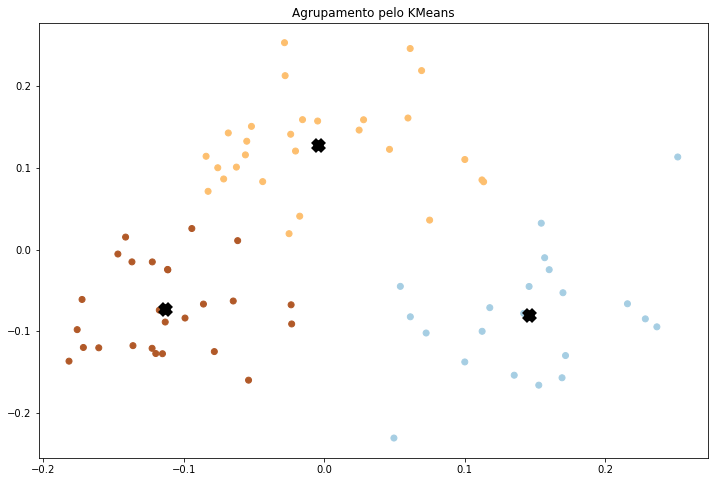

In [43]:
prepro1.graf()

Antes de criar nosso sistema de recomendação, iremos fazer mais uma análise, vamos ver a distancia de cada um dos pontos das clusterizações estão seu centro.

In [44]:
# centros dos clusters

centros = prepro1.kmeans.cluster_centers_

centros

array([[ 0.14583512, -0.08038071],
       [-0.00436446,  0.12756044],
       [-0.11308972, -0.0724499 ]])

In [45]:
# pegando cada componente da clusterização

componente0 = prepro1.principalComponents[prepro1.kmeans.labels_ == 0]
componente1 = prepro1.principalComponents[prepro1.kmeans.labels_ == 1]
componente2 = prepro1.principalComponents[prepro1.kmeans.labels_ == 2]

Agora vamos criar uma função para calcular a distância de cada um dos pontos desse clusters aos centros, e depois pegaremos o máximo de cada.

In [46]:
def dist(x,y):
    d = np.sqrt((x[0]-y[0])**2 + (x[1]-y[1])**2)
    return d

In [47]:
MaiorDistancia0 = max([dist(centros[0],y) for  y in componente0])
MaiorDistancia1 = max([dist(centros[0],y) for  y in componente1])
MaiorDistancia2 = max([dist(centros[0],y) for  y in componente2])

print(MaiorDistancia0, MaiorDistancia1, MaiorDistancia2)

0.22084207983129947 0.3763411041847631 0.33232230451564154


In [48]:
# relembrando as principais categorias dos clusters:

print(news_df["news_category"][prepro1.kmeans.labels_ == 0]) 
print(news_df["news_category"][prepro1.kmeans.labels_ == 1])
print(news_df["news_category"][prepro1.kmeans.labels_ == 2])

13    technology
25        sports
27        sports
30        sports
31        sports
33        sports
34        sports
35        sports
37        sports
38        sports
39        sports
40        sports
41        sports
42        sports
43        sports
44        sports
45        sports
46        sports
47        sports
48        sports
49        sports
Name: news_category, dtype: object
23    technology
26        sports
28        sports
32        sports
36        sports
50      politics
51      politics
53      politics
54      politics
55      politics
57      politics
58      politics
59      politics
60      politics
61      politics
62      politics
63      politics
64      politics
65      politics
66      politics
67      politics
68      politics
69      politics
70      politics
71      politics
72      politics
73      politics
74      politics
Name: news_category, dtype: object
0     technology
1     technology
2     technology
3     technology
4     technology
5     techno

Terminamos então toda a análise exploratória necessária para conseguirmos criar nosso sistema de recomendação dos textos.

# Sistema de recomendação.

Vamos criar um sistema de recomendação onde o usuário nos diz uma categoria de texto no qual ele quer ler algo sobre (tecnologia, sports ou politica) e o sistema retornará um dos textos do nosso dataset, em seguida o usuario vai indicar se gostou ou não do texto recomendado, caso ele tenha gostado, o programa será finalizado, caso ele não tenha gostado, o programa retornada outro texto da mesma categoria. Os textos que não forem bem avaliados serão todos salvos em uma lista, para que depois possamos fazer uma nova análise sobre eles e ver o que pode ter ocorrido para tal.

Claro que esse sistema é algo bem simples, porém é apenas uma ideia do que podemos fazer com dados relacionadoso a textos, trabalhando mais nele, aperfeicoando e o tornando mais eficiente.

### Estratégia para construção do sistema.

A classe que criaremos fará os seguintes passos:

__1: Pega o nome do tema escolhido pelo usuário__

__2: Escolhe o ponto mas perto do centro do cluster do tema escolhido__

__3: Retorna o texto e pede para o usuário avaliar positivamente ou negativamente o texto__

__4: Coloca na tebela de usuario-item a nota dada pela avaliação dele.__

__5: Além disso, caso o usuário queira ler outro texto do mesmo tema ou outro, ele terá essa opção.__

O mais interessante é que com o passar do tempo, a medida que os usuários forem se cadastrando no sistema, nos teremos uma tabela de recomendação mais robusta, podendo futuramente, fazer a sua fatoração ou alguma outra tecnica possível.



Construimos a classe do sistema de recomendação da seguinte forma:

__1 - Construtor da classe recebe o dataset, o nome da coluna que se encontra os textos, as categorias na ordem da clusterização feita pelo modelo.__

__2 - O método usuário adiciona o usuário a matriz de usuário x item.__

__3 - O método recomendação pede ao usuário o tema desejado e retorna um texto de acordo com os clusters, em seguida, já pede a avaliação do usuário e adiciona esse nota na tabela usuário x item.__



In [49]:
class sistemaAvaliacaoTextos():

    def __init__(self, data, coluna, categorias, modelo):
        self.data = data
        self.coluna = coluna
        self.categorias = categorias
        self.modelo = modelo
        df = np.empty([1, data.shape[0]])
        df[:] = np.nan
        self.tabelaRecomendação = pd.DataFrame(df)
        
    
    def usuario(self, user):
        self.user = user
        df1 = np.empty([1, self.data.shape[0]])
        df1[:] = np.nan
        self.tabelaRecomendação = pd.concat([self.tabelaRecomendação,pd.DataFrame(df1)], axis = 0).reset_index().drop('index', axis = 1)
        print('Usuário criado com sucesso')
        
    
    def recomendacao(self, i):
        self.listaCategorias = []
        for n in range(len(self.categorias)):
            X = self.modelo.data[self.modelo.kmeans.labels_ == n].reset_index()
            self.listaCategorias.append(X) 
        tema = input('Qual tema você deseja escolher para leitura?\n\n')
        for n1 in range(len(self.categorias)):
            if tema.lower() == self.categorias[n1]:
                print('\nTexto: \n')
                print(self.listaCategorias[n1][self.coluna][i])
                self.avaliacao(i, n1)
                
    def avaliacao(self, i, categ):
        self.lugarNota = []
        for n in range(len(self.data[self.coluna])):
            if self.data[self.coluna][n] == self.listaCategorias[categ][self.coluna][i]:
                self.lugarNota.append(n)
        
        ava = int(input('Qual nota você dá para o texto?'))
        while (ava <0) or (ava >5):
            print('A nota precisa tem que ser um valro entre 0 e 5')
            
        self.tabelaRecomendação.iloc[-1,self.lugarNota[0]] = float(ava)
        
        desejo = input('\nObrigado pela Avaliação. \n\nDeseja ler outro texto?\n\n')
        if desejo.lower() == 'sim':
            self.recomendacao(i+1)
        elif desejo.lower() == 'não':
            print('Agradecemos o uso do sistema e até breve!')
        else:
            print('Desculpa, mas não consegui entender, volte sempre.')
        
    
        

Vamos então criar o sistema usando o dataset 'news_df1', o modelo para clusterização 'prepro1' já criado anteriormente e as categorias ['sports', 'politics', 'technology'], pois como vimos mais acima, a clusterização foi feita nessa ordem.

In [50]:
recomenda1 = sistemaAvaliacaoTextos(news_df1, 'news_article', ['sports','politics','technology',], prepro1)

In [51]:
# criando um usuário

luan = recomenda1.usuario('luan')

Usuário criado com sucesso


In [52]:
# fazendo a recomendação e avaliação, iremos pedir um texto de cada categoria e analisar.

recomenda1.recomendacao(10)

Qual tema você deseja escolher para leitura?

sports

Texto: 

Rio de Janeiro officials will allow limited attendance of up to 6,500 spectators, or 10% of the Maracana Stadium's capacity, for Saturday's Copa America final between Brazil and Argentina, the Mayor's office said on Friday. Only those invited by South American football federation CONMEBOL will be allowed to attend. Attendees will be spread throughout the entire stadium this time.
Qual nota você dá para o texto?5

Obrigado pela Avaliação. 

Deseja ler outro texto?

sim
Qual tema você deseja escolher para leitura?

politics

Texto: 

Reacting to Union Minister Jyotiraditya Scindia's inclusion in Prime Minister Narendra Modi's cabinet, Madhya Pradesh Congress chief Kamal Nath on Friday said, "Ab kaise aage chalti hai gaadi wo dekha jayega (It will be seen how this vehicle moves forward)." "Cabinet berth is a matter between Scindia and the BJP. May he be happy," Nath added.  
Qual nota você dá para o texto?4

Obrigado pela Aval

### As recomendações baseadas nos clusters estão muito boas, é claro que podemos melhorar muito essa parte, principalmente se tratando de layout, porém já temos uma ideia de como o sistema funciona, vamos ver agora a tabela de recomendações

In [53]:
recomenda1.tabelaRecomendação

,0,1,2,3,4,5,6,7,8,9,...,65,66,67,68,69,70,71,72,73,74
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [56]:
# somando os valores da linha do usuário criado

recomenda1.tabelaRecomendação.iloc[1,:].sum()

11.0

Temos exatamente a soma das notas dadas pelo usuário (5 + 4 + 2), vamos então encontrar essas colunas especificas.

In [57]:
recomenda1.tabelaRecomendação.iloc[1,:].sort_values()

12    2.0
58    4.0
39    5.0
0     NaN
1     NaN
     ... 
70    NaN
71    NaN
72    NaN
73    NaN
74    NaN
Name: 1, Length: 75, dtype: float64

Encontramos então os textos com suas notas.

Como já dito, esse sistema é bem simples e muito pode ser melhorado, por exemplo, as notas dos usuários novos são sempre colocadas na última linha, porém se nosso sistema for on-line e mais de um usuário fizer o cadastro ao mesmo tempo, isso pode gerar conflitos, então temos que pensar como melhorar essa parte do código.

Porém mais uma vez também, a ideia aqui é mostrar a possibilidade de crar um sistema de recomendação de textos, tendo como base uma clusterização feita depois de um redimensionamento de textos vetorizados.

_________________________________________________________________________________________

# Classificação
 
Para finalizar vamos fazer mais uma coisa, agora iremos trabalhar com classificação, nesse caso, o usuário não pede um tema, e sim ao contrário, ele insere um texto, e o algoritmo retorna em qual das três categorias o texto se encontra.

Nesse caso o algoritmo vai receber o texto do usuario, fazer todo o pré-processamento nesse texto, e depois da vetorização, comparar a distancia dele com os centros dos clusters, e por fim, retornar a classificação do texto.

### Antes de criar a função, vamos fazer um passo a passo com um exemplo, peguei um texto curto do site da nba e vamos tentar classifica-lo.

In [58]:
teste = "You saw the box score, the team-high 31 points in the Suns’ 118-108 win. But it’s the timeliness and impact of Booker’s production that lifts him to the top spot in this latest installment of our NBA Finals MVP Ladder."

teste

'You saw the box score, the team-high 31 points in the Suns’ 118-108 win. But it’s the timeliness and impact of Booker’s production that lifts him to the top spot in this latest installment of our NBA Finals MVP Ladder.'

In [59]:
# fazendo o pré-processamento

textoProcessado = preprocess_text(teste)

In [60]:
print(textoProcessado)

['saw', 'box', 'score', 'team', 'high', 'points', 'suns', 'win', 'timeliness', 'impact', 'booker', 'production', 'lifts', 'spot', 'latest', 'installment', 'nba', 'finals', 'mvp', 'ladder']


In [61]:
# vetorizando o texto

matrix = np.empty([len(textoProcessado), 300])
for idx, word in enumerate(textoProcessado):
         matrix[idx,:] = vec(word)
final_feature_matrix = np.empty([1, 300])
final_feature_matrix = matrix.mean(axis = 0).reshape(1,-1)

In [62]:
# aplicando o ICA que treinamos na nossa classe criada mais acima

principalComponents = prepro1.ica.transform(final_feature_matrix)

In [63]:
principalComponents

array([[ 0.13475662, -0.19028812]])

In [64]:
# gora vamos calcular a distancia da componente do meu texto a cada um dos centros dos clusters

d1 = dist(principalComponents[0], centros[0])
d2 = dist(principalComponents[0], centros[1])
d3 = dist(principalComponents[0], centros[2])

[d1, d2, d3]

[0.11046434837435044, 0.3469616428563792, 0.2744333336772382]

Note que o ponto está mais perto do centro de label 0, que como já vimos mais acima, representa o agrupamento da categoria 'sports', portanto, temos um bom resultado.

Vamos ver graficamente.

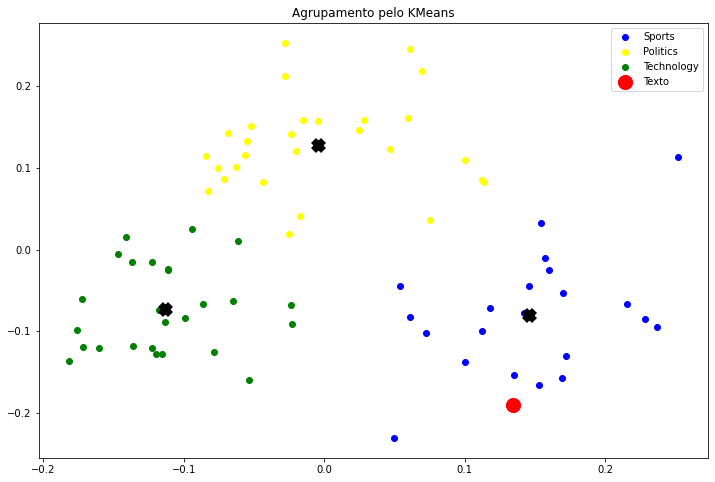

In [65]:
principalDf = pd.DataFrame(data = prepro1.principalComponents
             ,columns = ['principal component 1', 'principal component 2'])

sports = principalDf[prepro1.kmeans.labels_ == 0].reset_index()
politics = principalDf[prepro1.kmeans.labels_ == 1].reset_index()
technology = principalDf[prepro1.kmeans.labels_ == 2].reset_index()


plt.figure(figsize = [12,8])
plt.title('Agrupamento pelo KMeans')
plt.scatter(sports['principal component 1'], sports['principal component 2'],  
            c = 'blue', label = "Sports")
plt.scatter(politics['principal component 1'], politics['principal component 2'],  
            c = 'yellow', label = "Politics")  
plt.scatter(technology['principal component 1'], technology['principal component 2'],  
            c = 'green', label = "Technology")  

plt.scatter(principalComponents[0][0], principalComponents[0][1], c = 'red', s = 200, label = 'Texto')
for centr in prepro1.kmeans.cluster_centers_:
    plt.scatter(centr[0], centr[1], s = 100, marker = 'x', c = 'black', lw = 7)
plt.legend()
plt.show()

Conseguimos comprovar graficamente o que já tinhamos visto anteriormente.

Um ponto interessante é que conseguimos transformar todo nosso texto em um vetor com 2 coordenadas e com essas duas coordenadas, o algoritmo consegue encontrar a categoria dele.

Para finalizar, vamos criar uma função para fazer essa classificação e testar com alguns textos.

In [66]:
def classifi():
    texto = input("Digite o texto no qual você quer classificar aqui: \n\n")
    textoProcessado = preprocess_text(texto)
    matrix = np.empty([len(textoProcessado), 300])
    for idx, word in enumerate(textoProcessado):
         matrix[idx,:] = vec(word)
    final_feature_matrix = np.empty([1, 300])
    final_feature_matrix = matrix.mean(axis = 0).reshape(1,-1)
    principalComponents = prepro1.ica.transform(final_feature_matrix)
    d1 = dist(principalComponents[0], centros[0])
    d2 = dist(principalComponents[0], centros[1])
    d3 = dist(principalComponents[0], centros[2])
    lista = [d1,d2,d3]
    cluster = np.argmin(lista)
    if cluster == 0:
        print("\nO seu texto fala sobre Esportes")
    if cluster == 1:
        print("\nO seu texto fala sobre Politica")
    if cluster == 2:
        print("\nO seu texto fala sobre Tecnologia")

In [67]:
# vamos começar com o texto que usamos acima

classifi()

Digite o texto no qual você quer classificar aqui: 

You saw the box score, the team-high 31 points in the Suns’ 118-108 win. But it’s the timeliness and impact of Booker’s production that lifts him to the top spot in this latest installment of our NBA Finals MVP Ladder

O seu texto fala sobre Esportes


In [68]:
# agora um texto sobre a criação de um carro 

classifi()

Digite o texto no qual você quer classificar aqui: 

Created by British designer Thomas Heatherwick, it is hoped the Airo will go into production in China in 2023, with plans to make a million of them.

O seu texto fala sobre Tecnologia


In [69]:
# mais um exemplo

classifi()

Digite o texto no qual você quer classificar aqui: 

But Moscow denied US claims they had contacted the Russians repeatedly about the cyber-attacks in the past month.

O seu texto fala sobre Tecnologia


#### Note que apesar do texto poder se tratar também de política, ele fala sobre cyber-attacks, o que também nos permitiria classifica-lo como um texto sobre tecnologia.

Vamos fazer um último exemplo, com alguma noticia sobre política mundial.

In [70]:
classifi()

Digite o texto no qual você quer classificar aqui: 

The younger Biden's business dealings in Ukraine, China and elsewhere have often been held up by Republican critics as a conflict of interest for his father, which both Bidens deny.

O seu texto fala sobre Politica


#### Temos então mais um acerto na nossa classificação.

Concluimos aqui nosso notebook com todos os objetivos cumpridos.